<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Carteiras-Investimentos-Com-Rebalanceamentos/blob/main/Otimiza%C3%A7%C3%A3o_de_Carteiras_de_Investimentos_com_Rebalanceamentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
%%capture
pip install lifelines

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import WeibullAFTFitter, KaplanMeierFitter

In [4]:
# Simular ativos da carteira
ativos = ['PETR4', 'VALE3', 'ITUB4', 'BBDC4', 'MGLU3']
np.random.seed(42)
n = 100  # observações por ativo

In [5]:
# Parâmetros e frailty
lambda_base = 1.5
beta_base = 2.0
frailty_fatores = {'PETR4': 1.2, 'VALE3': 0.9, 'ITUB4': 1.0, 'BBDC4': 0.8, 'MGLU3': 1.5}

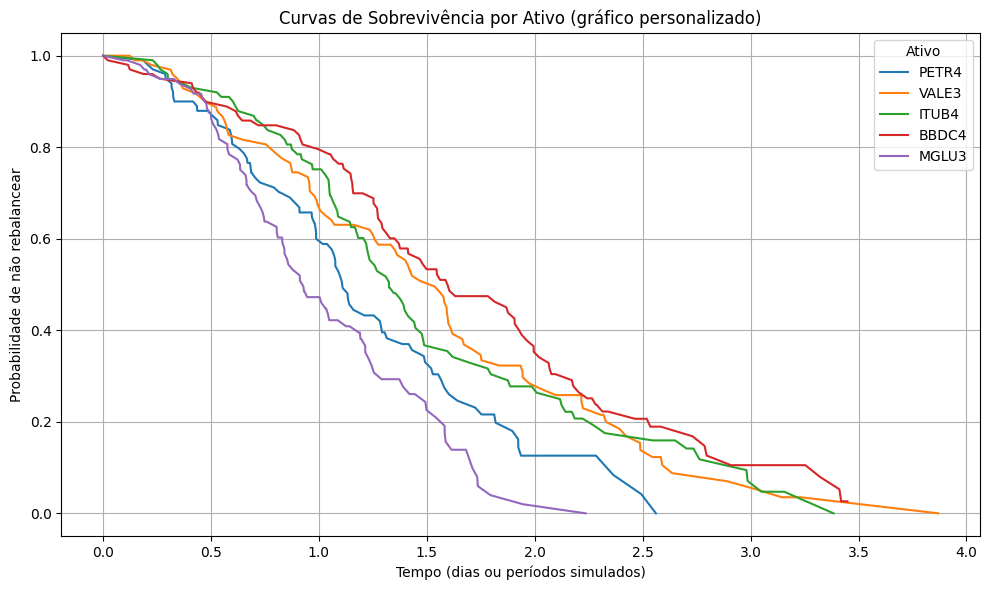

In [9]:
dados = []
for ativo in ativos:
    frailty = frailty_fatores[ativo]
    tempos = np.random.weibull(beta_base, n) * lambda_base / frailty
    evento = np.random.binomial(1, 0.8, n)
    for t, e in zip(tempos, evento):
        dados.append({'Ativo': ativo, 'Tempo': t, 'Evento': e})
df = pd.DataFrame(dados)

# ✅ Captura manual dos dados para plot personalizado
plt.figure(figsize=(10, 6))
for ativo in ativos:
    kmf = KaplanMeierFitter()
    mask = df['Ativo'] == ativo
    kmf.fit(df[mask]['Tempo'], event_observed=df[mask]['Evento'], label=ativo)

    # kmf.survival_function_ é um DataFrame com o tempo e probabilidade
    tempo = kmf.survival_function_.index
    prob = kmf.survival_function_[ativo]
    plt.plot(tempo, prob, label=ativo)

# Configuração personalizada
plt.title('Curvas de Sobrevivência por Ativo (gráfico personalizado)')
plt.xlabel('Tempo (dias ou períodos simulados)')
plt.ylabel('Probabilidade de não rebalancear')
plt.legend(title='Ativo')
plt.grid(True)
plt.tight_layout()
plt.show()